# **NIFTY 50 Closing Price Prediction using Recurrent Neural Networks (RNNs)**

# Importing Libraries

In [53]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, GRU
from tensorflow.keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.regularizers import l2
from numpy.random import seed
from tensorflow.random import set_seed
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

sns.set()
warnings.filterwarnings('ignore')
seed(42)
set_seed(42)

# Importing Data and Preprocessing

The data is downloaded from the following website:

https://www.nseindia.com/reports-indices-historical-index-data

I am focusing on the NIFTY 50 historical data.

**What is NIFTY 50?**

The NIFTY 50 is a stock market index comprising 50 of the largest and most liquid companies listed on the National Stock Exchange of India, representing various sectors of the Indian economy.

The website only allows to download the maximum of a year's data at a time, hence multiple files are downloaded.

In [2]:
folder_path = r'D:\PYTHON\00000 MACHINE LEARNING MAY\DAY9_STOCK_PRICE_PREDICTION'

files = os.listdir(folder_path)
files

['.ipynb_checkpoints',
 'DAY9_RNN.ipynb',
 'NIFTY 50-09-11-2015-to-12-05-2016.csv',
 'NIFTY 50-13-05-2016-to-12-05-2017.csv',
 'NIFTY 50-13-05-2017-to-12-05-2018.csv',
 'NIFTY 50-13-05-2018-to-12-05-2019.csv',
 'NIFTY 50-13-05-2019-to-12-05-2020.csv',
 'NIFTY 50-13-05-2020-to-12-05-2021.csv',
 'NIFTY 50-13-05-2021-to-12-05-2022.csv',
 'NIFTY 50-13-05-2022-to-12-05-2023.csv',
 'NIFTY 50-13-05-2023-to-10-05-2024.csv']

In [3]:
files.remove('.ipynb_checkpoints')
files.remove('DAY9_RNN.ipynb')

In [4]:
imported_files={}

for i, file_name in enumerate(files):
    df = pd.read_csv(os.path.join(folder_path,file_name))

    new_name = f'nifty_50_batch_{i+1}'
    imported_files[new_name] = df

In [5]:
imported_files.keys()

dict_keys(['nifty_50_batch_1', 'nifty_50_batch_2', 'nifty_50_batch_3', 'nifty_50_batch_4', 'nifty_50_batch_5', 'nifty_50_batch_6', 'nifty_50_batch_7', 'nifty_50_batch_8', 'nifty_50_batch_9'])

In [6]:
imported_files.values()

dict_values([           Date     Open     High      Low    Close   Shares Traded   \
0    09-NOV-2015  7788.25  7937.75  7771.70  7915.20       218422388   
1    10-NOV-2015  7877.60  7885.10  7772.85  7783.35       170267413   
2    11-NOV-2015  7838.80  7847.95  7819.10  7825.00        22380435   
3    13-NOV-2015  7762.45  7775.10  7730.90  7762.25       165876819   
4    16-NOV-2015  7732.95  7838.85  7714.15  7806.60       154134885   
..           ...      ...      ...      ...      ...             ...   
119  06-MAY-2016  7717.65  7738.90  7678.35  7733.45       168662226   
120  09-MAY-2016  7755.25  7873.65  7753.55  7866.05       165616829   
121  10-MAY-2016  7873.55  7896.90  7837.70  7887.80       166957276   
122  11-MAY-2016  7804.65  7893.10  7780.90  7848.85       220712496   
123  12-MAY-2016  7871.45  7916.05  7849.65  7900.40       157444918   

     Turnover (₹ Cr)  
0            9376.17  
1            7153.47  
2            1123.44  
3            7731.55  
4      

In [7]:
imported_files['nifty_50_batch_1']

,Date,Open,High,Low,Close,Shares Traded,Turnover (₹ Cr)
0,09-NOV-2015,7788.25,7937.75,7771.70,7915.20,218422388,9376.17
1,10-NOV-2015,7877.60,7885.10,7772.85,7783.35,170267413,7153.47
2,11-NOV-2015,7838.80,7847.95,7819.10,7825.00,22380435,1123.44
3,13-NOV-2015,7762.45,7775.10,7730.90,7762.25,165876819,7731.55
4,16-NOV-2015,7732.95,7838.85,7714.15,7806.60,154134885,6871.15
...,...,...,...,...,...,...,...
119,06-MAY-2016,7717.65,7738.90,7678.35,7733.45,168662226,6296.51
120,09-MAY-2016,7755.25,7873.65,7753.55,7866.05,165616829,7559.77
121,10-MAY-2016,7873.55,7896.90,7837.70,7887.80,166957276,7306.72
122,11-MAY-2016,7804.65,7893.10,7780.90,7848.85,220712496,9394.05


In [8]:
df = pd.DataFrame()

for batch in imported_files:
    df = pd.concat([df,imported_files[batch]],axis=0)

assert df.shape[0] == sum([imported_files[name].shape[0] for name in imported_files])

df.reset_index(inplace=True)
df.drop('index',axis=1,inplace=True)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2105 entries, 0 to 2104
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Date             2105 non-null   object 
 1   Open             2105 non-null   float64
 2   High             2105 non-null   float64
 3   Low              2105 non-null   float64
 4   Close            2105 non-null   float64
 5   Shares Traded    2104 non-null   float64
 6   Turnover (₹ Cr)  2104 non-null   float64
dtypes: float64(6), object(1)
memory usage: 115.2+ KB


In [10]:
df.dropna(inplace=True)

df.columns

Index(['Date ', 'Open ', 'High ', 'Low ', 'Close ', 'Shares Traded ',
       'Turnover (₹ Cr)'],
      dtype='object')

In [11]:
df.rename(columns={'Date ':'Date',
                     'Open ':'Open',
                     'Close ':'Close',
                     'High ':'High',
                     'Low ':'Low',
                     'Shares Traded ':'Shares Traded'}, inplace=True)

In [12]:
df['Date'] = pd.to_datetime(df['Date'])

In [13]:
df.head()

,Date,Open,High,Low,Close,Shares Traded,Turnover (₹ Cr)
0,2015-11-09,7788.25,7937.75,7771.70,7915.20,218422388.0,9376.17
1,2015-11-10,7877.60,7885.10,7772.85,7783.35,170267413.0,7153.47
2,2015-11-11,7838.80,7847.95,7819.10,7825.00,22380435.0,1123.44
3,2015-11-13,7762.45,7775.10,7730.90,7762.25,165876819.0,7731.55
4,2015-11-16,7732.95,7838.85,7714.15,7806.60,154134885.0,6871.15


Now that we have aggregated the data, let us focus on the **Close Price**.

In [14]:
close_df = df.filter(['Close'])
close_array = close_df.values

In [15]:
train_size

1684

In [16]:
close_array

array([[ 7915.2 ],
       [ 7783.35],
       [ 7825.  ],
       ...,
       [22302.5 ],
       [21957.5 ],
       [22055.2 ]])

**MinMaxScaler** is used to normalize the data within 0 and 1. This also helps in improving the convergence speed of the RNN models used later. 

In [42]:
scaler = MinMaxScaler(feature_range=(0, 1)) 
close_scaled = scaler.fit_transform(close_array)

# Splitting data into Training and Test sets

In [18]:
train_size = int(np.ceil(len(close_array)*0.8)) # 80% of the data is used for training

close_train = close_scaled[0:train_size,:]

X_train = []
y_train = []

timestep_size = 100 
# This means that, to predict the value at current timestep, 
# values of the 100 previous timesteps are taken into account.
# Thus, for y value (target) at timestep 't', the corresponding X (features)
# will be the values at timesteps (t-100), (t-99), ..., (t-2) and (t-1).

for i in range(0,len(close_train)-timestep_size):
    X_train.append(close_train[i : (i+timestep_size), 0])
    y_train.append(close_train[(i+timestep_size), 0])

X_train, y_train = np.array(X_train), np.array(y_train)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [19]:
X_train.shape, y_train.shape

((1584, 100, 1), (1584,))

In [20]:
close_test = close_scaled[train_size-timestep_size:,:]

X_test = []
y_test =  close_array[train_size:,:]

for i in range(0, len(close_test)-timestep_size):
    X_test.append(close_test[i : (i+timestep_size), 0])

X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

In [21]:
X_test.shape, y_test.shape

((420, 100, 1), (420, 1))

# Long Short-Term Memory (LSTM)

LSTM is a type of RNN. It is primarily used to tackle the problem of vanishing gradients, through the use of its gating mechanisms. These mechanisms enable LSTM networks to retain, forget, or update information in the cell state.

In this example, I have used 3 stacked LSTMs, each with 50 hidden units.

For regularization, I have used Dropout with rate = 0.5.

## Model Building

In [22]:
dropout_rate=0.5

model_LSTM = Sequential()

model_LSTM.add(LSTM(units=50, 
               return_sequences=True,
               input_shape=(X_train.shape[1],1)))

model_LSTM.add(Dropout(dropout_rate))

model_LSTM.add(LSTM(units=50, 
               return_sequences=True))

model_LSTM.add(Dropout(dropout_rate))

model_LSTM.add(LSTM(units=50, 
               return_sequences=False))

model_LSTM.add(Dropout(dropout_rate))

model_LSTM.add(Dense(units=1))

model_LSTM.compile(optimizer=Adam(), loss='mse')

model_LSTM.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100, 50)        │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100, 50)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100, 50)        │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100, 50)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1,restore_best_weights=True)

In [24]:
history = model_LSTM.fit(X_train, 
                         y_train, 
                         batch_size=64, 
                         validation_split=0.2, 
                         validation_batch_size=64,
                         callbacks=[early_stopping],
                         epochs=100)

Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 118ms/step - loss: 0.0295 - val_loss: 0.0234
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - loss: 0.0046 - val_loss: 0.0012
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - loss: 0.0031 - val_loss: 0.0012
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 0.0026 - val_loss: 0.0017
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - loss: 0.0027 - val_loss: 0.0011
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - loss: 0.0023 - val_loss: 0.0011
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - loss: 0.0022 - val_loss: 0.0011
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - loss: 0.0022 - val_loss: 0.0011
Epoch 9/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 0.0018 - val_loss: 0.0016
Epoch 10/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - loss: 0.0021 - val_loss: 0.0012
Epoch 11/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 0.0022 - val_loss: 0.0011
Epoch 12/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/ste

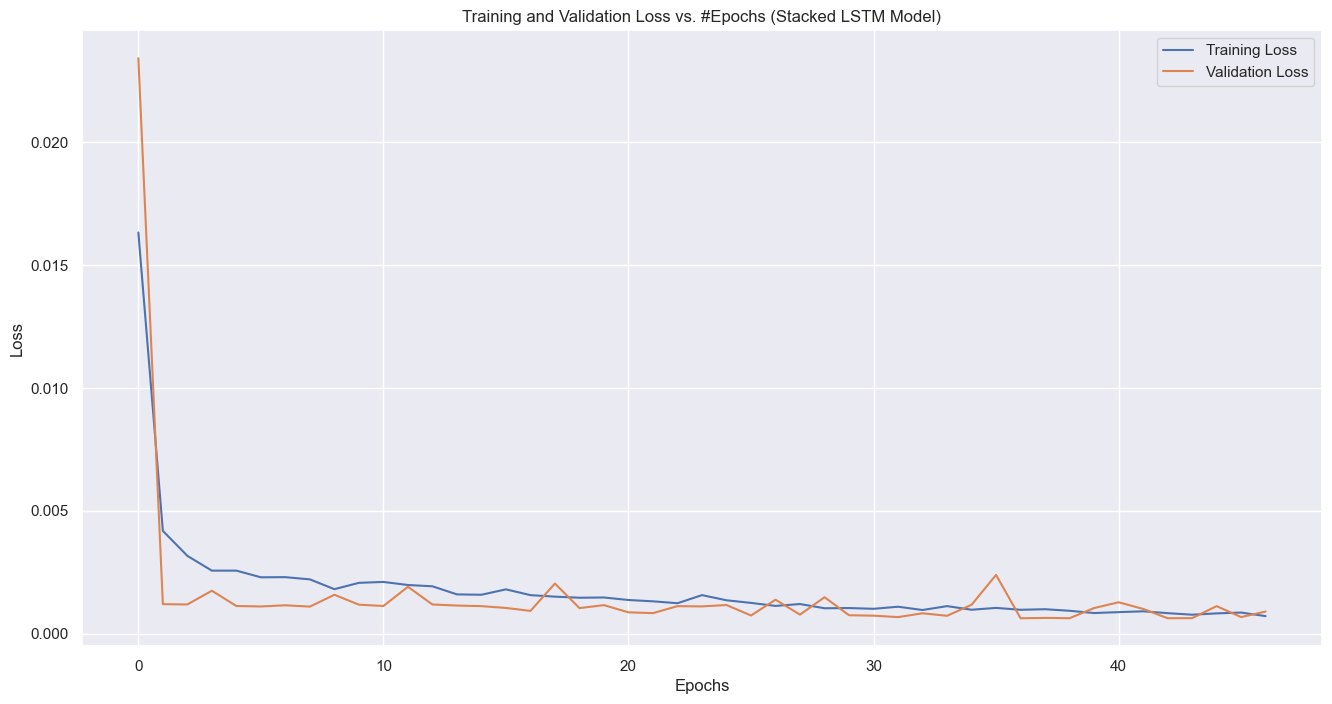

In [25]:
plt.figure(figsize=(16,8))
plt.title('Training and Validation Loss vs. #Epochs (Stacked LSTM Model)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

In [26]:
y_train_pred_scaled_LSTM = model_LSTM.predict(X_train)
y_test_pred_scaled_LSTM = model_LSTM.predict(X_test) 

y_train_pred_LSTM = scaler.inverse_transform(y_train_pred_scaled_LSTM)
y_test_pred_LSTM = scaler.inverse_transform(y_test_pred_scaled_LSTM)

50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


## Metrics

In [49]:
rmse_train_LSTM = np.sqrt(mean_squared_error(y_train_pred_LSTM, y_train))
rmse_test_LSTM = np.sqrt(mean_squared_error(y_test_pred_LSTM, y_test))

rmse_train_LSTM, rmse_test_LSTM

(12313.8977718674, 293.3351018885572)

In [51]:
r2_train_LSTM = r2_score(y_train_pred_LSTM, y_train)
r2_test_LSTM = r2_score(y_test_pred_LSTM, y_test)

r2_train_LSTM, r2_test_LSTM

(-16.898069475879364, 0.9679653769639508)

In [54]:
mae_train_LSTM = mean_absolute_error(y_train_pred_LSTM, y_train)
mae_test_LSTM = mean_absolute_error(y_test_pred_LSTM, y_test)

mae_train_LSTM, mae_test_LSTM

(11964.997962989617, 236.1161365327381)

## Plots

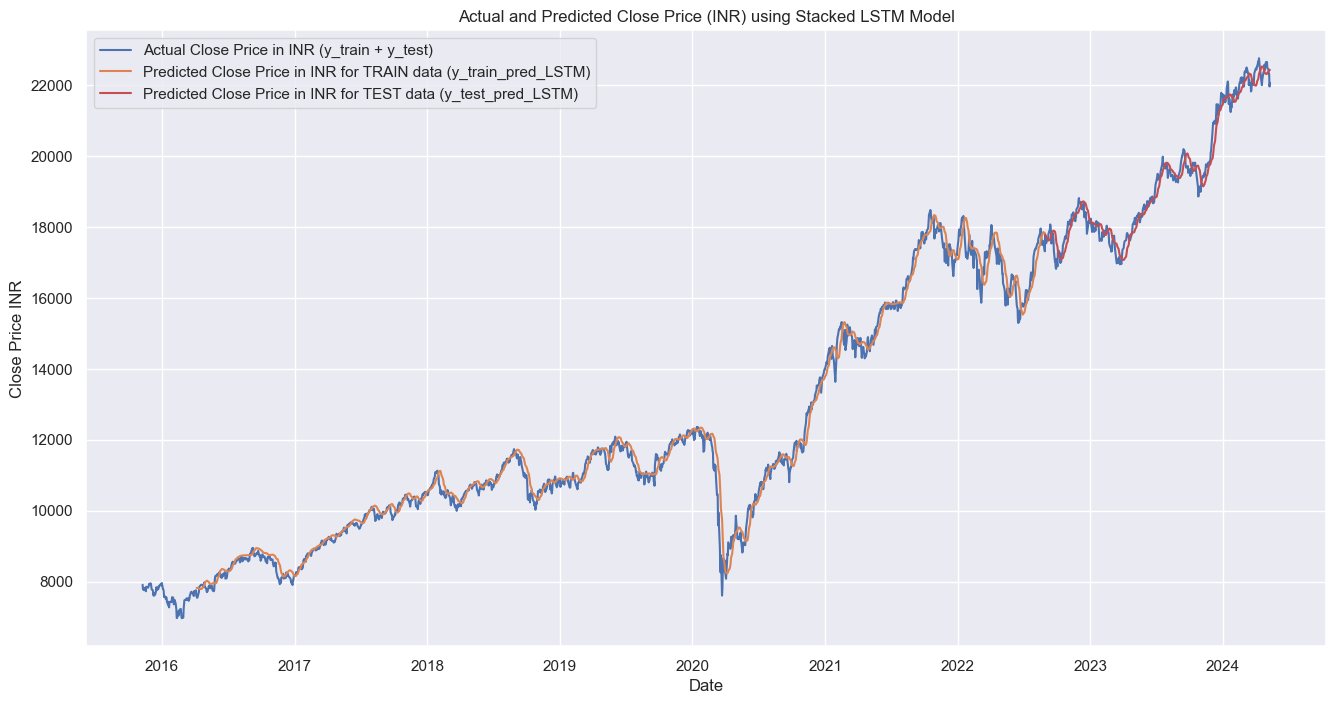

In [43]:
plt.figure(figsize=(16,8))
plt.title('Actual and Predicted Close Price (INR) using Stacked LSTM Model')
plt.xlabel('Date')
plt.ylabel('Close Price INR')
plt.plot(df['Date'], close_df, label='Actual Close Price in INR (y_train + y_test)')
plt.plot(df['Date'][timestep_size:train_size], y_train_pred_LSTM, label='Predicted Close Price in INR for TRAIN data (y_train_pred_LSTM)')
plt.plot(df['Date'][train_size:], y_test_pred_LSTM, color='r', label='Predicted Close Price in INR for TEST data (y_test_pred_LSTM)')
plt.legend()
plt.show()

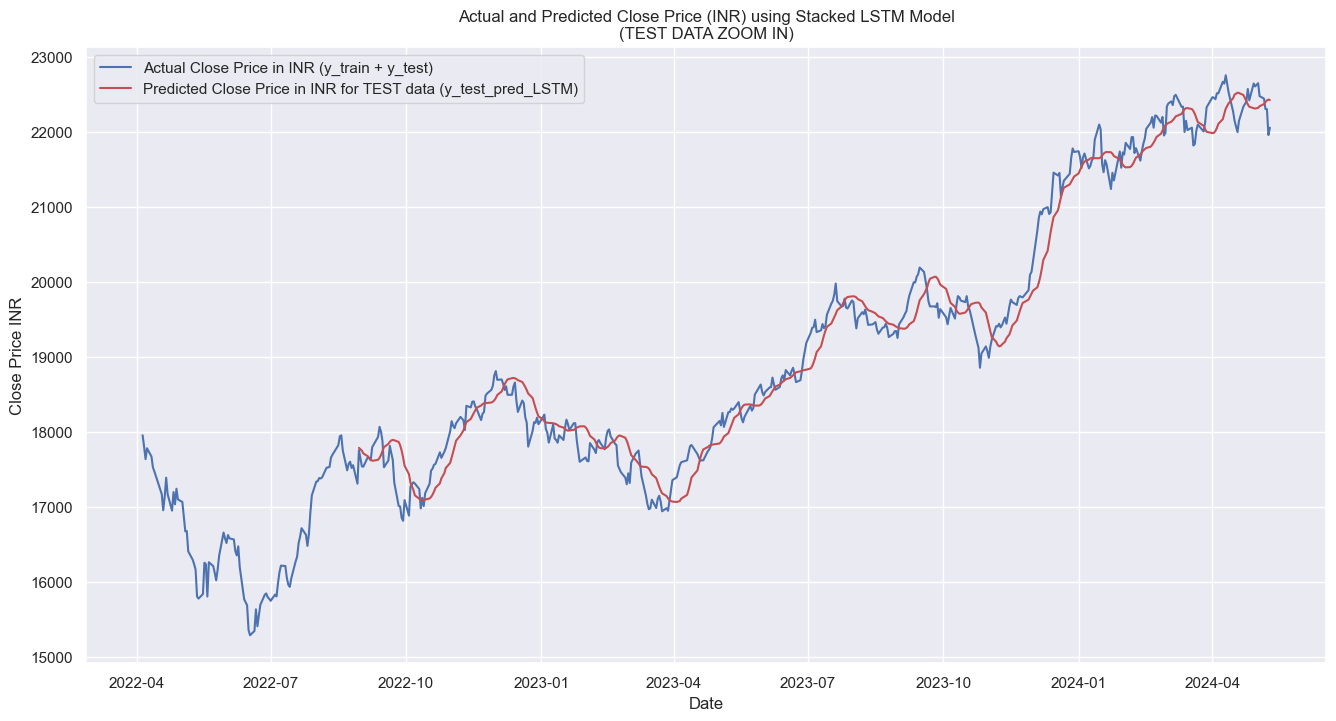

In [46]:
plt.figure(figsize=(16,8))
plt.title('Actual and Predicted Close Price (INR) using Stacked LSTM Model\n(TEST DATA ZOOM IN)')
plt.xlabel('Date')
plt.ylabel('Close Price INR')
plt.plot(df['Date'][train_size-timestep_size:], close_df[train_size-timestep_size:], label='Actual Close Price in INR (y_train + y_test)')
plt.plot(df['Date'][train_size:], y_test_pred_LSTM, color='r', label='Predicted Close Price in INR for TEST data (y_test_pred_LSTM)')
plt.legend()
plt.show()

**Observation**: The LSTM seems to capture the upward and downward patterns. However, for given number of epochs and early stopping criteria, it fails to capture the smaller patterns and underfits too much. It seems that more number of epochs are required for a better convergence point.

LSTM can be more prone to longer training times due to its larger number of parameters and complexity. 

Let us see a modification of LSTMs.

In [67]:
model_LSTM.save('model_LSTM.keras')

# Gated Recurrent Units (GRUs)

GRUs are also type of RNNs. They are similar to LSTMs, designed to capture long-range sequential data. They have simplified gating mechanisms compared to LSTMs, making them computationally more efficient and potentially easier to train, while still effectively addressing the vanishing gradient problem.

## Model Building

In [30]:
model_GRU = Sequential()

model_GRU.add(GRU(units=50, 
                  return_sequences=True,
                  input_shape=(X_train.shape[1],1)))

model_LSTM.add(Dropout(dropout_rate))

model_GRU.add(GRU(units=50, 
                  return_sequences=True))

model_LSTM.add(Dropout(dropout_rate))

model_GRU.add(GRU(units=50, 
                  return_sequences=False))

model_LSTM.add(Dropout(dropout_rate))

model_GRU.add(Dense(units=1))

model_GRU.compile(optimizer=Adam(), loss='mse')

model_GRU.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 100, 50)        │         7,950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 100, 50)        │        15,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 50)             │        15,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,601 (150.79 KB)

 Trainable params: 38,601 (150.79 KB)

 Non-trainable params: 0 (0.00 B)

In [31]:
history2 = model_GRU.fit(X_train, 
                         y_train, 
                         batch_size=64, 
                         validation_split=0.2, 
                         validation_batch_size=64,
                         callbacks=[early_stopping],
                         epochs=100)

Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 148ms/step - loss: 0.0281 - val_loss: 0.0494
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - loss: 0.0024 - val_loss: 0.0055
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - loss: 3.8419e-04 - val_loss: 6.2534e-04
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - loss: 2.3229e-04 - val_loss: 4.1678e-04
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - loss: 1.9594e-04 - val_loss: 3.9518e-04
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - loss: 1.8818e-04 - val_loss: 3.5855e-04
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - loss: 1.8209e-04 - val_loss: 3.5153e-04
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - loss: 1.7694e-04 - val_loss: 3.3505e-04
Epoch 9/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - loss: 1.7190e-04 - val_loss: 3.2085e-04
Epoch 10/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step - loss: 1.6717e-04 - val_loss: 3.0722e-04
Epoch 11/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - loss: 1.

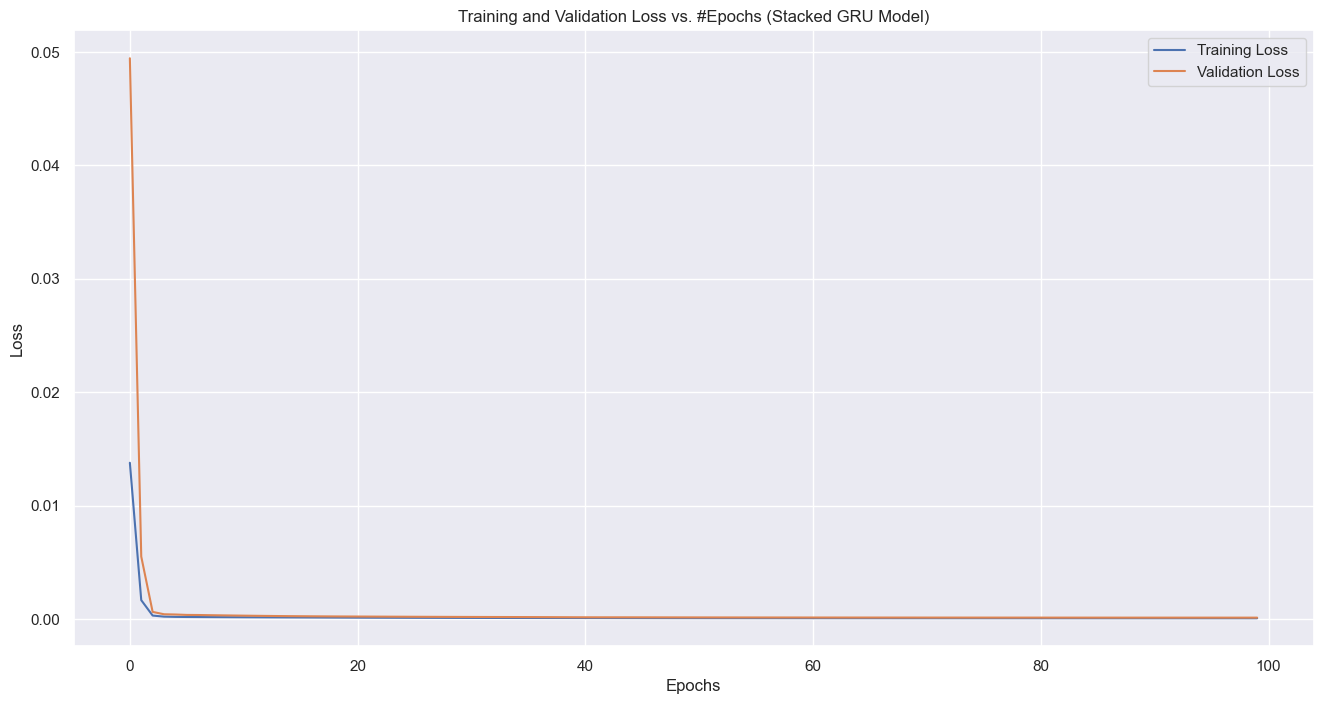

In [32]:
plt.figure(figsize=(16,8))
plt.title('Training and Validation Loss vs. #Epochs (Stacked GRU Model)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(history2.history['loss'], label='Training Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

In [33]:
y_train_pred_scaled_GRU = model_GRU.predict(X_train)
y_test_pred_scaled_GRU = model_GRU.predict(X_test) 

y_train_pred_GRU = scaler.inverse_transform(y_train_pred_scaled_GRU)
y_test_pred_GRU = scaler.inverse_transform(y_test_pred_scaled_GRU)

50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


## Metrics

In [50]:
rmse_train_GRU = np.sqrt(mean_squared-10:_error(y_train_pred_GRU, y_train))
rmse_test_GRU = np.sqrt(mean_squared_error(y_test_pred_GRU, y_test))

rmse_train_GRU, rmse_test_GRU

(12256.56038993273, 156.06075421440437)

In [52]:
r2_train_GRU = r2_score(y_train_pred_GRU, y_train)
r2_test_GRU = r2_score(y_test_pred_GRU, y_test)

r2_train_GRU, r2_test_GRU

(-16.481243841468338, 0.9911244723727244)

In [55]:
mae_train_GRU = mean_absolute_error(y_train_pred_GRU, y_train)
mae_test_GRU = mean_absolute_error(y_test_pred_GRU, y_test)

mae_train_GRU, mae_test_GRU

(11900.8808540955, 123.80230003720239)

## Plots

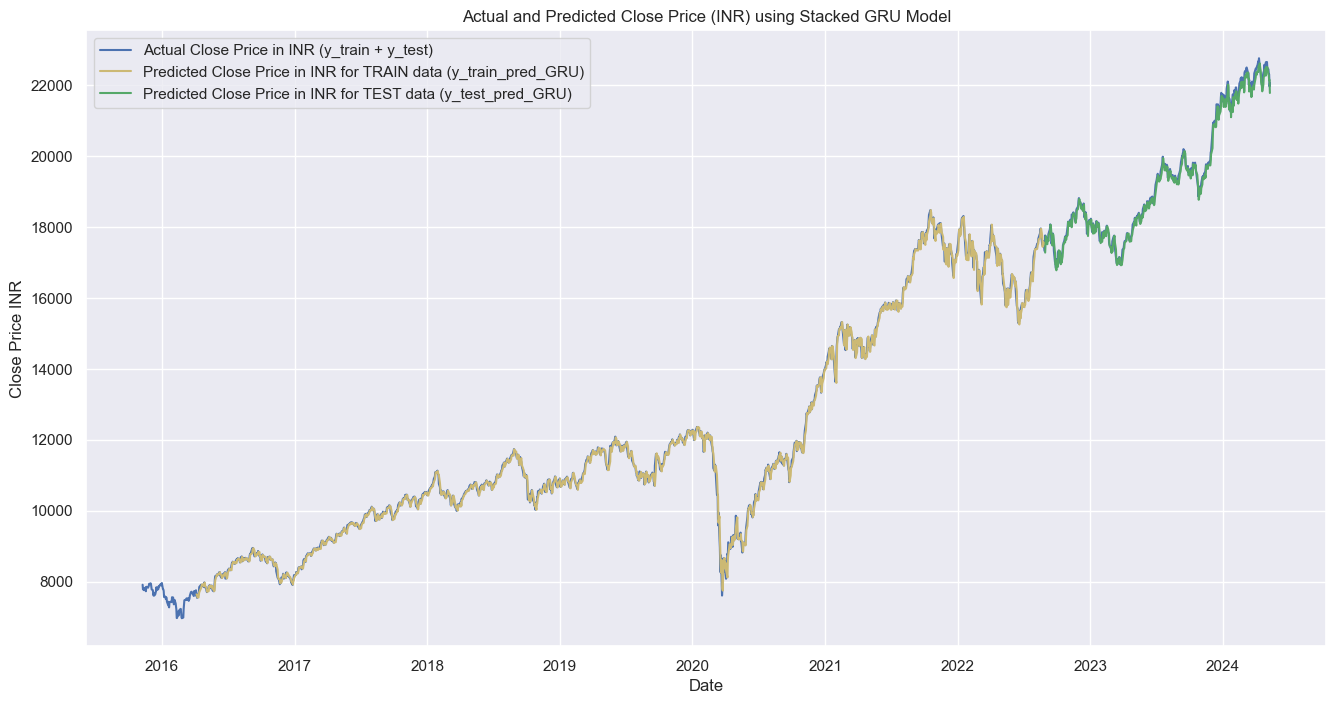

In [62]:
plt.figure(figsize=(16,8))
plt.title('Actual and Predicted Close Price (INR) using Stacked GRU Model')
plt.xlabel('Date')
plt.ylabel('Close Price INR')
plt.plot(df['Date'], close_df, label='Actual Close Price in INR (y_train + y_test)')
plt.plot(df['Date'][timestep_size:train_size], y_train_pred_GRU, color='y', label='Predicted Close Price in INR for TRAIN data (y_train_pred_GRU)')
plt.plot(df['Date'][train_size:], y_test_pred_GRU, color='g', label='Predicted Close Price in INR for TEST data (y_test_pred_GRU)')
plt.legend()
plt.show()

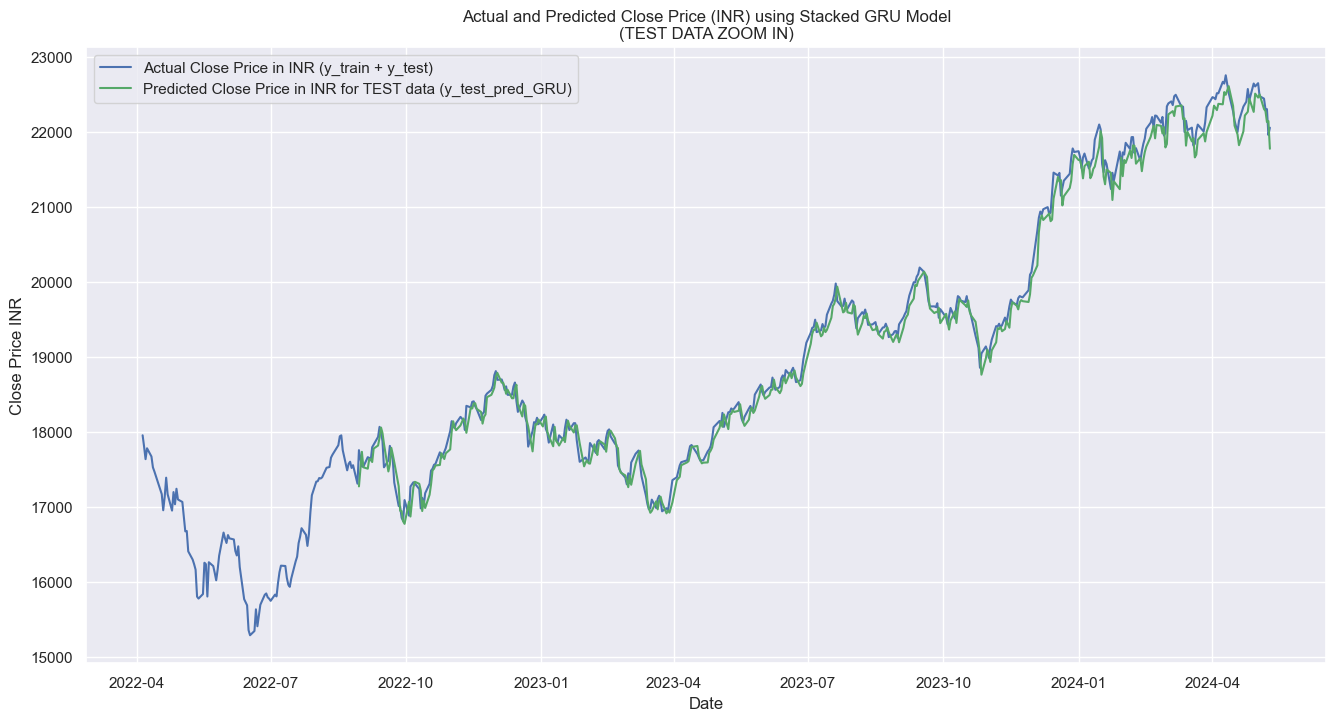

In [63]:
plt.figure(figsize=(16,8))
plt.title('Actual and Predicted Close Price (INR) using Stacked GRU Model\n(TEST DATA ZOOM IN)')
plt.xlabel('Date')
plt.ylabel('Close Price INR')
plt.plot(df['Date'][train_size-timestep_size:], close_df[train_size-timestep_size:], label='Actual Close Price in INR (y_train + y_test)')
plt.plot(df['Date'][train_size:], y_test_pred_GRU, color='g', label='Predicted Close Price in INR for TEST data (y_test_pred_GRU)')
plt.legend()
plt.show()

**Observation**: Under same hyperparameters and conditions, GRUs seem to drastically outperform LSTMs!

In [68]:
model_GRU.save('model_GRU.keras')

# Actual Values vs. LSTM Predictions vs. GRU Predictions

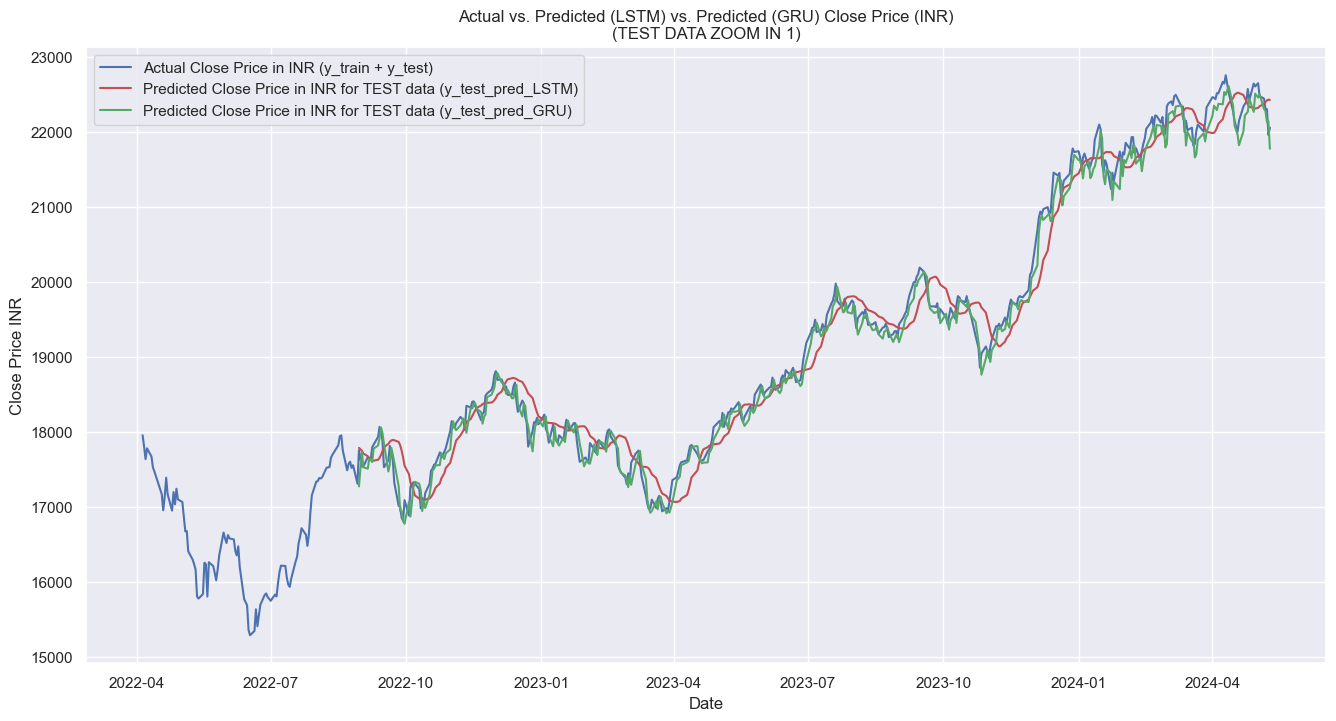

In [65]:
plt.figure(figsize=(16,8))
plt.title('Actual vs. Predicted (LSTM) vs. Predicted (GRU) Close Price (INR)\n(TEST DATA ZOOM IN 1)')
plt.xlabel('Date')
plt.ylabel('Close Price INR')
plt.plot(df['Date'][train_size-timestep_size:], close_df[train_size-timestep_size:], label='Actual Close Price in INR (y_train + y_test)')
plt.plot(df['Date'][train_size:], y_test_pred_LSTM, color='r', label='Predicted Close Price in INR for TEST data (y_test_pred_LSTM)')
plt.plot(df['Date'][train_size:], y_test_pred_GRU, color='g', label='Predicted Close Price in INR for TEST data (y_test_pred_GRU)')
plt.legend()
plt.show()

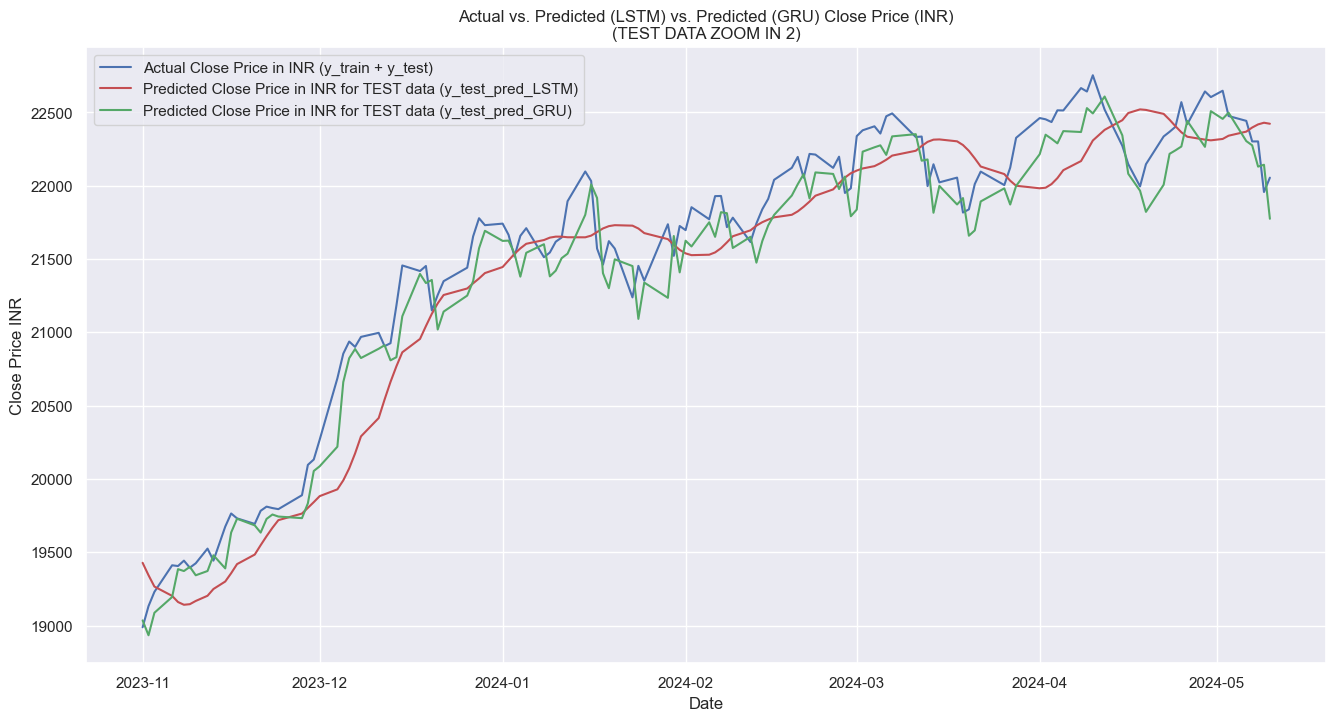

In [66]:
plt.figure(figsize=(16,8))
plt.title('Actual vs. Predicted (LSTM) vs. Predicted (GRU) Close Price (INR)\n(TEST DATA ZOOM IN 2)')
plt.xlabel('Date')
plt.ylabel('Close Price INR')
plt.plot(df['Date'][-130:], close_df[-130:], label='Actual Close Price in INR (y_train + y_test)')
plt.plot(df['Date'][-130:], y_test_pred_LSTM[-130:], color='r', label='Predicted Close Price in INR for TEST data (y_test_pred_LSTM)')
plt.plot(df['Date'][-130:], y_test_pred_GRU[-130:], color='g', label='Predicted Close Price in INR for TEST data (y_test_pred_GRU)')
plt.legend()
plt.show()

# Metrics Comparison

In [59]:
results = {
    'RNN' : ['LSTM','GRU'],
    'Training RMSE' : [rmse_train_LSTM, rmse_train_GRU],
    'Test RMSE' : [rmse_test_LSTM, rmse_test_GRU],
    'Training MAE' : [mae_train_LSTM, mae_train_GRU],
    'Test MAE' : [mae_test_LSTM, mae_test_GRU],
    'Training R2' : [r2_train_LSTM, r2_train_GRU],
    'Test R2' : [r2_test_LSTM, r2_test_GRU]
}

round(pd.DataFrame(results),3)

,RNN,Training RMSE,Test RMSE,Training MAE,Test MAE,Training R2,Test R2
0,LSTM,12313.898,293.335,11964.998,236.116,-16.898,0.968
1,GRU,12256.560,156.061,11900.881,123.802,-16.481,0.991
